In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from yelib.utils.network_util import ProxyContext

In [3]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [4]:
with ProxyContext(proxy="http://192.168.1.45:10809"):
    dataset = get_dataset("m4_hourly")

entering proxy context http://192.168.1.45:10809
exit proxy context http://192.168.1.45:10809


In [9]:
entry = next(iter(dataset.train))

In [24]:
entry.keys()
_iter = iter(dataset.train)

In [27]:
entry = next(_iter)
print(len(entry['target']), entry['feat_static_cat'])

700 [2]


In [17]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='414')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=48)

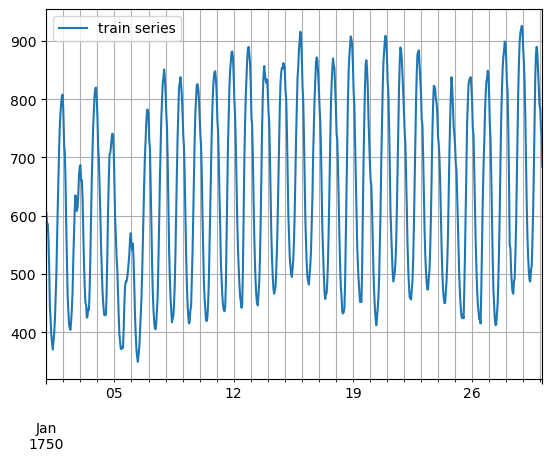

In [28]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

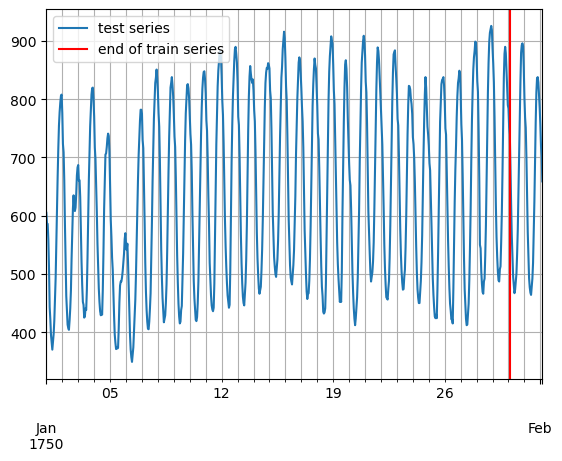

In [29]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [32]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)},\n{train_series.index[0]}, {train_series.index[-1]}, {test_series.index[0]}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48,
1750-01-01 00:00, 1750-01-30 03:00, 1750-01-01 00:00
Recommended prediction horizon: 48
Frequency of the time series: H


In [37]:
from gluonts.torch import SimpleFeedForwardEstimator

estimator = SimpleFeedForwardEstimator(
    hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
)

In [38]:
predictor = estimator.train(dataset.train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\73915\.conda\envs\py38\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
c:\Users\73915\.conda\envs\py38\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | SimpleFeedForwardModel | 48.5 K
-------------------------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 5.65984 (best 5.65984), saving model to 'd:\\code\\learn\\pylearn\\ML\\time_series\\lightning_logs\\version_0\\checkpoints\\epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 4.96501 (best 4.96501), saving model to 'd:\\code\\learn\\pylearn\\ML\\time_series\\lightning_logs\\version_0\\checkpoints\\epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 4.71163 (best 4.71163), saving model to 'd:\\code\\learn\\pylearn\\ML\\time_series\\lightning_logs\\version_0\\checkpoints\\epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 4.60881 (best 4.60881), saving model to 'd:\\code\\learn\\pylearn\\ML\\time_series\\lightning_logs\\version_0\\checkpoints\\epoch=3-step=200.ckpt' as top 1
INFO:pytorch_light

In [39]:
from gluonts.evaluation import make_evaluation_predictions
# A pair of iterators, the first one yielding the forecasts, and the
#         second one yielding the corresponding ground truth series.
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [40]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [44]:
# first entry of the time series list
ts_entry = tss[0]
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:40]).reshape(-1,)

array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370., 383.,
       397., 420., 455., 493., 554., 610., 666., 715., 755., 778., 794.,
       806., 808., 776., 723., 709., 660., 585., 527., 462., 437., 413.,
       407., 404., 420., 441., 471., 526., 571.], dtype=float32)

In [45]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))
# first 5 values
dataset_test_entry["target"][:40]

array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370., 383.,
       397., 420., 455., 493., 554., 610., 666., 715., 755., 778., 794.,
       806., 808., 776., 723., 709., 660., 585., 527., 462., 437., 413.,
       407., 404., 420., 441., 471., 526., 571.], dtype=float32)